In [1]:
import matplotlib
import matplotlib.pyplot as plt
import gzip, pickle
import numpy as np
from tsCluster import tsCluster as tsc
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from notebooks.helper import get_onehot_codes
import pandas as pd
import random
import pyriemann
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
import os
import seaborn as sn
import pandas as pd
import re
import scipy

#
from sklearn.cluster import KMeans

#pip install pyriemann
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.distance import distance_riemann

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, SVR
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import mapper

Using cmappertools v1.0.24.


/anaconda3/envs/dodtin/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/anaconda3/envs/dodtin/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
matplotlib.__version__

'3.0.3'

In [3]:
def get_label_4_old(str_inp):
    if str_inp == 'ctr':
        return 0
    if str_inp == 'hl':
        return 1
    if str_inp == 'tin_hl':
        return 2
    if str_inp == 'tin':
        return 3

In [4]:
def get_label_8(str_inp,loc):
    if loc == 'chm':
        to_add = 0
    elif loc == 'san':
        to_add = 1
    else:
        raise ValueError("Invalid location")
    
    if str_inp == 'ctr':
        return 0 + to_add
    if str_inp == 'hl':
        return 2 + to_add
    if str_inp == 'tin_hl':
        return 4 + to_add
    if str_inp == 'tin':
        return 6 + to_add

In [5]:
def get_label_4(str_inp):
    return str_inp

In [6]:
def get_label_4_tin_thresh(str_inp,name,metadata):
    if str_inp == 'ctr':
        return 0
    if str_inp == 'hl':
        return 1
    if str_inp == 'tin_hl':
        if metadata.loc[int(re.sub(r'sub_','',name)),'TFI_A'] <= 25:
            return 2
        else:
            return 3
    if str_inp == 'tin':
        if metadata.loc[int(re.sub(r'sub_','',name)),'TFI_A'] <= 25:
            return 4
        else:
            return 5
        

In [7]:
def get_label_4_tin_thresh2(str_inp,name,metadata):
    if str_inp == 'ctr':
        return 0
    if str_inp == 'hl':
        return 1
    if str_inp == 'tin_hl' or str_inp == 'tin':
        if metadata.loc[int(re.sub(r'sub_','',name)),'TFI_A'] <= 25:
            return 2
        else:
            return 3
        

## Create result directories

In [8]:
try:
    os.mkdir('RiemannResults')
except FileExistsError:
    pass

In [9]:
data_dir = 'new_data/'

## Number of features is larger than number of samples, so linear kernel should be used in svm

In [10]:
meta_dir = 'metadata/'

In [11]:
valid_runs_uiuc = pd.read_csv(meta_dir + 'UIUC_valid_runs.csv',index_col='ID',header=0,names=['ID','A','B','C','D','E','F','G'],usecols=['ID','A','B'])

In [12]:
valid_runs_whasc = pd.read_csv(meta_dir + 'WHASC_valid_runs.csv',index_col='ID',header=0,names=['ID','A','B','C','D'],usecols=['ID','A','B'])

In [13]:
valid_runs_dict_uiuc = {re.sub(r'\d+_','',idx.rstrip('*')): row.values for idx,row in valid_runs_uiuc.iterrows()}

In [14]:
valid_runs_dict_whasc = {re.sub(r'\d+_','',idx.rstrip('*')): row.values for idx,row in valid_runs_whasc.iterrows()}

In [15]:
valid_runs_dict_uiuc.keys()

dict_keys(['113', '115', '117', '120', '122', '123', '126', '166', '167', '168', '169', '199', '200', '220', '258', '259', '261', '275', '294', '125', '189', '191', '201', '226', '230', '243', '253', '265', '270', '271', '273', '284', '285', '295', '298', '299', '103', '130', '135', '136', '150', '157', '182', '216', '218', '233', '274', '276', '286', '287', '291', '292', '102', '105', '106', '108', '129', '131', '133', '140', '146', '152', '153', '154', '158', '160', '162', '163', '174', '176', '178', '184', '187', '188', '197', '205', '207', '208', '210', '213', '217', '219', '222', '223', '227', '246', '247', '255', '256', '257', '277', '279', '280', '282', '293'])

In [16]:
valid_runs_dict_whasc.keys()

dict_keys(['102', '107', '118', '124', '166', '174', '180', '194', '195', '200', '201', '205', '206', '209', '211', '212', '214', '117', '122', '161', '179', '183', '184', '185', '186', '210', '213', '217', '109', '113', '116', '126', '127', '145', '156', '162', '167', '168', '189', '193', '196', '198', '199', '108', '110', '119', '120', '121', '132', '143', '144', '146', '150', '151', '152', '154', '155', '159', '164', '170', '171', '173', '175', '177', '191', '197', '202', '208'])

In [17]:
metadata_uiuc = pd.read_csv(meta_dir + 'UIUC_metadata.csv',index_col = 'ID')
metadata_whasc = pd.read_csv(meta_dir + 'WHASC_metadata.csv',index_col = 'ID')

In [76]:
uiuc_files = [data_dir+'UIUC/'+fname for fname in os.listdir(data_dir+'UIUC') if not fname.startswith('.')]

In [77]:
whasc_files = [data_dir+'WHASC/'+fname for fname in os.listdir(data_dir+'WHASC') if not fname.startswith('.')]

In [78]:
uiuc_samples = []
count =0
for fname_prefix in uiuc_files:
    runs = [run for run in os.listdir(fname_prefix) if run.startswith('run')]
    for run in runs:
        count += 1
        ID = re.findall(r'\d+_(\d+)_',fname_prefix)[0]
        Group_binary = re.findall(r'(\d+)_\d+_',fname_prefix)[0][1:]
        if Group_binary == "00":
            Group = 'ctr'
        if Group_binary == "01":
            Group = 'hl'
        if Group_binary == "10":
            Group = 'tin'
        if Group_binary == "11":
            Group = 'tin_hl'
        
        filename = "ROI_matrix_data_33.csv"
        try:
            timeSeries = np.genfromtxt(fname_prefix+'/'+run+'/'+filename,delimiter=',')
        except OSError:
            continue
            
        if timeSeries.shape[0] == 33:
            uiuc_samples.append({'TimeSeries':timeSeries,'Location':'chm','Run':run,'ID':ID,'Group':Group})
print(count)            

/anaconda3/envs/dodtin/lib/python3.7/site-packages/ipykernel/__main__.py:20: UserWarning: genfromtxt: Empty input file: "new_data/UIUC/Fh_001_285_B/run5/ROI_matrix_data_33.csv"


478


In [79]:
whasc_samples = []
for fname_prefix in whasc_files:
    runs = [run for run in os.listdir(fname_prefix) if run.startswith('run')]
    for run in runs:
        ID = re.findall(r'\d+_(\d+)_',fname_prefix)[0]
        Group_binary = re.findall(r'(\d+)_\d+_',fname_prefix)[0][1:]
        if Group_binary == "00":
            Group = 'ctr'
        if Group_binary == "01":
            Group = 'hl'
        if Group_binary == "10":
            Group = 'tin'
        if Group_binary == "11":
            Group = 'tin_hl'
        filename = "ROI_matrix_data_33.csv"
        timeSeries = np.genfromtxt(fname_prefix+'/'+run+'/'+filename,delimiter=',')
        
        whasc_samples.append({'TimeSeries':timeSeries,'Location':'san','Run':run,'ID':ID,'Group':Group})

In [80]:
with gzip.open('bin_data/nogsr_data33_tv_linear.bin','rb') as stream:
    data_old = pickle.load(stream)
X = np.array([sample['TimeSeries'] for sample in data_old.samples ])

In [81]:
data = {'samples':uiuc_samples+whasc_samples}

In [82]:
len(data['samples'])

769

In [83]:
X = np.array([sample['TimeSeries'] for sample in data['samples'] if data_selector(sample)])

In [84]:
len(X)

328

In [85]:
len(set([x['Name'] for x in data_old.samples]))

105

In [86]:
len(set([x['ID'] for x in data['samples']]))

138

In [95]:
def data_selector(sample):
    if sample['Location'] == 'chm':
        cond1 = int(sample['Run'].lstrip('run')) in valid_runs_dict_uiuc.get(sample['ID'],[])
    elif sample['Location'] == 'san':
        cond1 = int(sample['Run'].lstrip('run')) in valid_runs_dict_whasc.get(sample['ID'],[])
    else:
        raise Exception("Invalid Location")
    cond2 = int(sample['Run'].lstrip('run')) != 3
    return cond1 and cond2

In [224]:
def data_selector_2(sample):
    cond1 = int(re.sub(r'sub_','',sample['Name'])) in metadata.index
    cond2 = int(sample['Run'].lstrip('run')) <= 2
    return cond1 and cond2

In [225]:
def data_selector_music(sample):
    cond1 = int(re.sub(r'sub_','',sample['Name'])) in metadata.index
    cond2 = int(sample['Run'].lstrip('run')) == 3
    return cond1 and cond2

In [88]:
from sklearn.base import BaseEstimator, TransformerMixin
class PCA_coord_change(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pca_instance = PCA()
        
    def fit(self,X,y=None):
        
        self.pca_instance.fit(X,y)
        return self
    
    def transform(self,X):
        shape = X.shape
        coords = self.pca_instance.components_
        coord_shape = coords.shape
        if coord_shape[1] < shape[0]:
            coords_padded = np.hstack([coords, np.zeros((coord_shape[0],-coord_shape[1]+shape[0]))])
            X_padded = X
        else:
            coords_padded = coords
            X_padded = np.vstack([X,np.zeros((coord_shape[1]-shape[0],shape[1]))])
        return np.dot(coords_padded,X_padded)
       
    
    def fit_transform(self,X,y=None,sample_weight=None):
        
        self.pca_instance.fit(X,y)
        shape = X.shape
        coords = self.pca_instance.components_
        coord_shape = coords.shape
        if coord_shape[1] < shape[0]:
            coords_padded = np.hstack([coords, np.zeros((coord_shape[0],-coord_shape[1]+shape[0]))])
            X_padded = X
        else:
            coords_padded = coords
            X_padded = np.vstack([X,np.zeros((coord_shape[1]-shape[0],shape[1]))])
        return np.dot(coords_padded,X_padded)
        
    
class to_upper_tri(BaseEstimator, TransformerMixin):
    def __init__(self,k):
        self.k = k
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        shape = X[0].shape
        inds = np.triu_indices(shape[0],self.k)
        return np.array([x[inds].flatten() for x in X])
    
    def fit_transform(self,X,y=None,sample_weight=None):
        shape = X[0].shape
        inds = np.triu_indices(shape[0],self.k)
        return np.array([x[inds].flatten() for x in X])
    
class to_diag(BaseEstimator, TransformerMixin):
    def __init__(self,rows):
        self.rows=rows
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return np.array([np.array([x[i,i] for i in range(0,self.rows)]).flatten() for x in X])
    
    def fit_transform(self,X,y=None,sample_weight=None):
        shape = X[0].shape
        
        return np.array([np.array([x[i,i] for i in range(0,self.rows)]).flatten() for x in X])

    
class to_symm_mat(BaseEstimator, TransformerMixin):
    def __init__(self,k,rows):
        self.k = k
        self.rows=rows
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        inds = np.triu_indices(self.rows,self.k)
        to_ret = []
        for x in X:
            zeroed = np.zeros(shape=(self.rows,self.rows))
            zeroed[inds] = x
            to_ret.append((zeroed+zeroed.T)/(np.eye(self.rows)+np.ones((self.rows,self.rows))))
        return np.array(to_ret)
    
    def fit_transform(self,X,y=None,sample_weight=None):
        inds = np.triu_indices(self.rows,self.k)
        to_ret = []
        for x in X:
            zeroed = np.zeros(shape=(self.rows,self.rows))
            zeroed[inds] = x
            to_ret.append((zeroed+zeroed.T)/(np.eye(self.rows)+np.ones((self.rows,self.rows))))
        return np.array(to_ret)

In [89]:
class Correlations(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return np.array([np.corrcoef(x) for x in X])
    
    def fit_transform(self,X,y=None):
        return np.array([np.corrcoef(x) for x in X])

In [114]:
metadata_uiuc.index

Int64Index([113, 115, 117, 120, 122, 123, 126, 166, 167, 168, 169, 199, 200,
            220, 258, 259, 261, 275, 294, 125, 189, 191, 201, 226, 230, 243,
            253, 265, 270, 271, 273, 284, 285, 295, 298, 299, 103, 130, 135,
            136, 150, 157, 182, 216, 218, 233, 274, 276, 286, 287, 291, 292,
            102, 105, 106, 108, 129, 131, 133, 140, 146, 152, 153, 154, 158,
            160, 162, 163, 174, 176, 178, 184, 187, 188, 197, 205, 207, 208,
            210, 213, 217, 219, 222, 223, 227, 246, 247, 255, 256, 257, 277,
            279, 280, 282, 293],
           dtype='int64', name='ID')

In [115]:
def get_TFI(sample):
    if sample["Location"] == "chm":
        return metadata_uiuc.loc[int(sample['ID']),'TFI_A']
    if sample["Location"] =="san":
        return metadata_whasc.loc[int(sample['ID']),'TFI_A']

In [123]:
data = {'samples':uiuc_samples+whasc_samples}
        


# get time series data to make covariance matrices
X = np.array([(sample['TimeSeries'], get_TFI(sample)) for sample in data['samples'] if get_TFI(sample) != 0])# if data_selector(sample)])        


    
covest = Covariances()
ut = to_upper_tri()
transformer = make_pipeline(covest,ut)
fiber = transformer.transform(np.array([x[0] for x in X]))
proj = np.array([x[1] for x in X])

In [124]:
fiber.shape

(263, 561)

In [125]:
ind_x,ind_y = np.triu_indices(33)

In [126]:
indices = list(zip(list(ind_x),list(ind_y)))

In [127]:
rf = RandomForestRegressor(100)
ts_test = TangentSpace()
clf = make_pipeline(covest,ts_test,rf)
clf.fit(np.array([sample['TimeSeries'] for sample in data['samples'] if get_TFI(sample) != 0]),proj)
cross_val_score(clf,np.array([sample['TimeSeries'] for sample in data['samples'] if get_TFI(sample) != 0]),proj)

array([0.22967461, 0.13152613, 0.05780004, 0.19862173, 0.17825495])

In [128]:
indices[np.argmax(clf[2].feature_importances_)]

(6, 15)

In [130]:
(data_old.rois[15],data_old.rois[17])

('medialprefrontalcortex', 'precuneus')

In [131]:
len(rf.estimators_)

100

In [132]:
fiber_covs = covest.transform(np.array([x[0] for x in X]))
num_samps = fiber_covs.shape[0]
len_dist = scipy.special.binom(num_samps,2)
dist_mat = np.zeros((num_samps*(num_samps-1))//2)
for j,x in enumerate(fiber_covs):
    for i in range(0,j):
        index = int(len_dist - scipy.special.binom(num_samps-i,2) + (j-i-1))
        dist_mat[index] = pyriemann.utils.distance.distance_riemann(fiber_covs[i],fiber_covs[j])


In [133]:
distances = np.array(dist_mat)
distances.shape

(34453,)

In [134]:
out = mapper.mapper(distances,proj,mapper.cover.cube_cover_primitive(20),mapper.cutoff.biggest_gap(),cluster=mapper._mapper.centroid_linkage())

Number of observations: 263.
Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.Mapper: Filter range in dimension 0: [2.00, 82.40]

Mapper: Cover: Hypercube cover. Intervals: (20,). Overlap: (50.0,)
Mapper: Clustering: Centroid linkage clustering
Mapper: Cutoff: Biggest logarithmic gap
Level: (0,)
Level: (1,)
Level: (2,)Filter level (0,) has 39 points.Filter level (1,) has 55 points.
Level: (3,)
Level: (4,)
Level: (5,)
Level: (6,)
Level: (7,)
Level: (8,)
Filter level (2,) has 53 points.
Level: (9,)Filter level (3,) has 42 points.

Level: (10,)
Level: (11,)
Level: (12,)
Level: (13,)
Level: (14,)
Level: (15,)
Level: (16,)
Level: (17,)
Level: (18,)
Level: (19,)


Filter level (4,) has 34 points.Filter level (5,) has 51 points.
Filter level (6,) has 51 points.

Filter level (7,) has 41 points.
Filter level (8,) has 28 points.
Filter level (9,) has 25 points.Filter level (10,) has 32 points.

Filter level (11,) has 28 points.
Fi

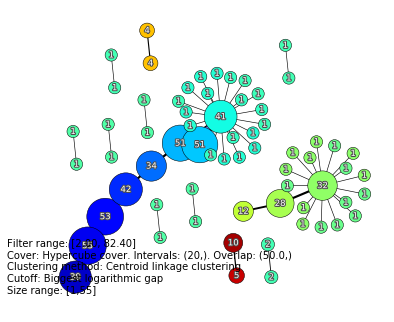

In [135]:
eat = mapper.draw_mapper_output.draw_2D(out)
plt.savefig("mapper.png",bbox_inches='tight')

In [136]:
out = mapper.mapper(fiber,proj,mapper.cover.cube_cover_primitive(20),mapper.cutoff.biggest_gap(),cluster=mapper._mapper.single_linkage())

Number of CPU cores present: 4
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Start Mapper thread.
Mapper: Filter range in dimension 0: [2.00, 82.40]
Mapper: Cover: Hypercube cover. Intervals: (20,). Overlap: (50.0,)
Mapper: Clustering: Single linkage clustering
Mapper: Cutoff: Biggest logarithmic gap
Level: (0,)
Level: (1,)
Level: (2,)
Level: (3,)
Level: (4,)
Level: (5,)
Level: (6,)
Level: (7,)
Level: (8,)
Level: (9,)
Level: (10,)
Level: (11,)
Level: (12,)
Level: (13,)
Level: (14,)
Level: (15,)
Level: (16,)
Level: (17,)
Level: (18,)
Level: (19,)
Filter level (0,) has 39 points.Filter level (1,) has 55 points.Filter level (2,) has 53 points.


Filter level (3,) has 42 points.
Filter level (4,) has 34 points.Filter level (5,) has 51 points.

Filter level (6,) has 51 points.
Filter level (7,) has 41 points.
Filter level (8,) has 28 points.
Filter level (9,) has 25 points.Filter level (10,) has 32 points.Filter level (11,) has 28 points.


Filter level (12,) has 12 points.

/anaconda3/envs/dodtin/lib/python3.7/site-packages/mapper/cutoff.py:159: RuntimeWarning: divide by zero encountered in true_divide
  ratios = h2 / heights


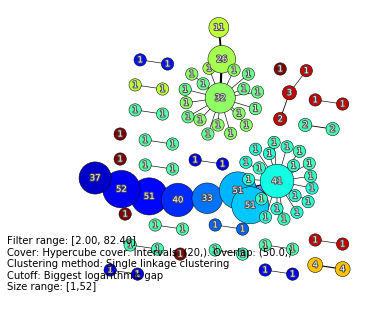

In [137]:
eat = mapper.draw_mapper_output.draw_2D(out)

In [230]:
test = to_symm_mat(0,2)
test.transform([[0,1,2]])

array([[[0., 1.],
        [1., 2.]]])

In [107]:
def train_classifiers(data_files):
    accDict = {}
    simDict = {}
    matDict = {}
    corrDict = {}
    spearDict = {}
    
    simArr = []
    for fname,data in data_files:
        # get time series data to make covariance matrices
        X = np.array([sample['TimeSeries'] for sample in data['samples']])# if data_selector(sample)])        
        y = np.array([get_label_8(sample['Group'],sample['Location']) for sample in data['samples']])# if data_selector(sample)])

        # gsr seems to produce a rank deficient covariance matrix, so oas regularization is necessary
        covest = Covariances()  
        ts = TangentSpace()
        #sym = to_symm_mat(0,33)
        #diag = to_upper_tri(1)
        svc = SVC(kernel='linear')
        clf_riem = make_pipeline(covest,ts,svc)

        rf = RandomForestClassifier(200)
        clf_rf = make_pipeline(covest,ts,rf)


        covest2 = Correlations()

        svc2 = SVC(kernel='linear')
        get_tri_inds = to_upper_tri(0)
        clf_cov = make_pipeline(covest2,get_tri_inds,svc2)


        #Check clustering
        #to_TS = make_pipeline(covest,ts)
        #X_in_TS = to_TS.transform(X)
        #kmeans = KMeans(n_clusters=4,random_state=0).fit(X_in_TS)

        # Monte Carlo, in theory should run this len(y)^2 times, but I need to save my poor computer's memory.
        accRiemList = []
        accCovList = []
        accRfList = []
        coeffArr = []
        matRiemList = []
        corrArrBefore = []
        corrArrAfter = []
        spearArrBefore = []
        spearArrAfter = []

        rs = StratifiedShuffleSplit(n_splits=100, test_size=.3)
        for i,(train_inds,test_inds) in enumerate(rs.split(X,y)):

            X_train, X_test, y_train, y_test = X[train_inds],X[test_inds],y[train_inds],y[test_inds]
            X_train_cov, X_test_cov, y_train_cov, y_test_cov = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

            clf_riem.fit(X_train,y_train)
            clf_rf.fit(X_train,y_train)
            clf_cov.fit(X_train_cov,y_train_cov)


            #get riemann svm coefficients
            coeffArr.append(clf_riem[2].coef_)

            #compare correlation
            corr_coeffs_before = np.corrcoef(np.vstack([x[np.triu_indices(33)].flatten() for x in X_train]),rowvar=False)
            corrArrBefore.append(np.linalg.norm(corr_coeffs_before))
            #spearman correlation
            spearman_coeffs_before,_ = scipy.stats.spearmanr(np.vstack([x[np.triu_indices(33)].flatten() for x in X_train]),axis=0)
            spearArrBefore.append(np.linalg.norm(spearman_coeffs_before))

            ref = ts.reference_
            covs = covest.transform(X_train)
            mapped = ts.transform(covs)
            corr_coeffs_after = np.corrcoef(mapped,rowvar=False)
            spearman_coeffs_after = scipy.stats.spearmanr(mapped,axis=0)
            corrArrAfter.append(np.linalg.norm(corr_coeffs_after))
            spearArrAfter.append(np.linalg.norm(spearman_coeffs_after))

            y_pred = clf_riem.predict(X_test)
            y_pred_cov = clf_cov.predict(X_test_cov)
            y_pred_rf = clf_rf.predict(X_test)

            # save accuracy
            accRiemList.append(accuracy_score(y_pred,y_test))
            accCovList.append(accuracy_score(y_pred_cov,y_test_cov))
            accRfList.append(accuracy_score(y_pred_rf,y_test))

            # confusion matrix
            mat = confusion_matrix(y_test,y_pred,normalize='true',labels=[0,1,2,3,4,5,6,7])
            matRiemList.append(mat)

        for z in range(0,len(coeffArr[0])):
            class_z_coeffs = [x[z] for x in coeffArr]
            cos_sim = cosine_similarity(class_z_coeffs)
            upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
            cos_avg = np.mean(upperTri.flatten())
            simArr.append(cos_avg)

        avgMatRiem = sum(matRiemList)/len(matRiemList)
        simDict.update({fname: simArr}) 
        matDict.update({fname: avgMatRiem})
        riemAcc = np.mean(accRiemList)
        covAcc = np.mean(accCovList)
        rfAcc = np.mean(accRfList)

        accDict.update({'raw_data':{'riem':riemAcc, 'rf':rfAcc, 'cov':covAcc}})
        corrDict.update({'raw_data':{'before':np.mean(corrArrBefore),'after':np.mean(corrArrAfter)}}) 
        spearDict.update({'raw_data':{'before':np.mean(spearArrBefore),'after':np.mean(spearArrAfter)}}) 
        print("Mean Accuracy w/ Riemann on data " + fname + ": " + str(riemAcc))
        print("Mean Accuracy w/ Cov on data " + fname + ": " + str(covAcc))
        print("Mean Accuracy w/ RF on data " + fname + ": " + str(rfAcc))
        print("----------------")
    
    return accDict, corrDict, spearDict, matDict, simDict


In [109]:
dicts = train_classifiers([['raw_data',{'samples':uiuc_samples+whasc_samples}]])

Mean Accuracy w/ Riemann on data raw_data: 0.8349350649350648
Mean Accuracy w/ Cov on data raw_data: 0.5139393939393939
Mean Accuracy w/ RF on data raw_data: 0.5383549783549784
----------------


In [97]:
fname = 'raw_data'

accDict = {}
simDict = {}
matDict = {}
corrDict = {}
spearDict = {}

data = {'samples':uiuc_samples+whasc_samples}
        
simArr = []

# get time series data to make covariance matrices
X = np.array([sample['TimeSeries'] for sample in data['samples']])# if data_selector(sample)])        
y = np.array([get_label_8(sample['Group'],sample['Location']) for sample in data['samples']])# if data_selector(sample)])

# gsr seems to produce a rank deficient covariance matrix, so oas regularization is necessary
covest = Covariances()  
ts = TangentSpace()
#sym = to_symm_mat(0,33)
#diag = to_upper_tri(1)
svc = SVC(kernel='linear')
clf_riem = make_pipeline(covest,ts,svc)

rf = RandomForestClassifier(200)
clf_rf = make_pipeline(covest,ts,rf)


covest2 = Correlations()

svc2 = SVC(kernel='linear')
get_tri_inds = to_upper_tri(0)
clf_cov = make_pipeline(covest2,get_tri_inds,svc2)


#Check clustering
#to_TS = make_pipeline(covest,ts)
#X_in_TS = to_TS.transform(X)
#kmeans = KMeans(n_clusters=4,random_state=0).fit(X_in_TS)

# Monte Carlo, in theory should run this len(y)^2 times, but I need to save my poor computer's memory.
accRiemList = []
accCovList = []
accRfList = []
coeffArr = []
matRiemList = []
corrArrBefore = []
corrArrAfter = []
spearArrBefore = []
spearArrAfter = []

rs = StratifiedShuffleSplit(n_splits=100, test_size=.3)
for i,(train_inds,test_inds) in enumerate(rs.split(X,y)):

    X_train, X_test, y_train, y_test = X[train_inds],X[test_inds],y[train_inds],y[test_inds]
    X_train_cov, X_test_cov, y_train_cov, y_test_cov = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

    clf_riem.fit(X_train,y_train)
    clf_rf.fit(X_train,y_train)
    clf_cov.fit(X_train_cov,y_train_cov)


    #get riemann svm coefficients
    coeffArr.append(clf_riem[2].coef_)

    #compare correlation
    corr_coeffs_before = np.corrcoef(np.vstack([x[np.triu_indices(33)].flatten() for x in X_train]),rowvar=False)
    corrArrBefore.append(np.linalg.norm(corr_coeffs_before))
    #spearman correlation
    spearman_coeffs_before,_ = scipy.stats.spearmanr(np.vstack([x[np.triu_indices(33)].flatten() for x in X_train]),axis=0)
    spearArrBefore.append(np.linalg.norm(spearman_coeffs_before))

    ref = ts.reference_
    covs = covest.transform(X_train)
    mapped = ts.transform(covs)
    corr_coeffs_after = np.corrcoef(mapped,rowvar=False)
    spearman_coeffs_after = scipy.stats.spearmanr(mapped,axis=0)
    corrArrAfter.append(np.linalg.norm(corr_coeffs_after))
    spearArrAfter.append(np.linalg.norm(spearman_coeffs_after))

    #for flattened in mapped:

        #mat = np.zeros((33,33))
        #mat[np.triu_indices(33)] = flattened
        #mat = (mat + mat.T)/2
        #mapped_mats.append(mat)

    #print(np.mean(np.array([distance_riemann(x,ref) for x in covs])-np.array([np.linalg.norm(x,ord='fro') for x in mapped_mats])/np.array([distance_riemann(x,ref) for x in covs])))

    y_pred = clf_riem.predict(X_test)
    y_pred_cov = clf_cov.predict(X_test_cov)
    y_pred_rf = clf_rf.predict(X_test)

    # save accuracy
    accRiemList.append(accuracy_score(y_pred,y_test))
    accCovList.append(accuracy_score(y_pred_cov,y_test_cov))
    accRfList.append(accuracy_score(y_pred_rf,y_test))

    # confusion matrix
    mat = confusion_matrix(y_test,y_pred,normalize='true',labels=[0,1,2,3,4,5,6,7])
    #plot_confusion_matrix(clf_riem, X_test, y_test,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
    #plt.savefig('RiemannResults/' + fname + '/ConfMatRiemRun' + str(i) + '.png',bbox_inches='tight')
    #plt.close()
    matRiemList.append(mat)

for z in range(0,len(coeffArr[0])):
    class_z_coeffs = [x[z] for x in coeffArr]
    cos_sim = cosine_similarity(class_z_coeffs)
    upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
    cos_avg = np.mean(upperTri.flatten())
    simArr.append(cos_avg)

avgMatRiem = sum(matRiemList)/len(matRiemList)
simDict.update({fname: simArr}) 
matDict.update({fname: avgMatRiem})
riemAcc = np.mean(accRiemList)
covAcc = np.mean(accCovList)
rfAcc = np.mean(accRfList)

accDict.update({'raw_data':{'riem':riemAcc, 'rf':rfAcc, 'cov':covAcc}})
corrDict.update({'raw_data':{'before':np.mean(corrArrBefore),'after':np.mean(corrArrAfter)}}) 
spearDict.update({'raw_data':{'before':np.mean(spearArrBefore),'after':np.mean(spearArrAfter)}}) 
print("Mean Accuracy w/ Riemann on file " + fname + ": " + str(riemAcc))
print("Mean Accuracy w/ Cov on file " + fname + ": " + str(covAcc))
print("Mean Accuracy w/ RF on file " + fname + ": " + str(rfAcc))
print("----------------")


Mean Accuracy w/ Riemann on file raw_data: 0.837012987012987
Mean Accuracy w/ Cov on file raw_data: 0.5138961038961039
Mean Accuracy w/ RF on file raw_data: 0.5397835497835498
----------------


In [231]:
X = np.array([sample['TimeSeries'] for sample in data['samples'] if data_selector(sample)])  
y = np.array([get_label_8(sample['Group'],sample['Location']) for sample in data['samples'] if data_selector(sample)])


In [232]:
to_mat= to_symm_mat(0,33)
transformed = to_mat.transform(clf_riem[:2].transform(X))

In [233]:
transformed[0].shape

(33, 33)

In [234]:
class_indices = [[ind for ind,x in enumerate(y) if x == j] for j in range(0,8)]

In [235]:
class_list = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san']

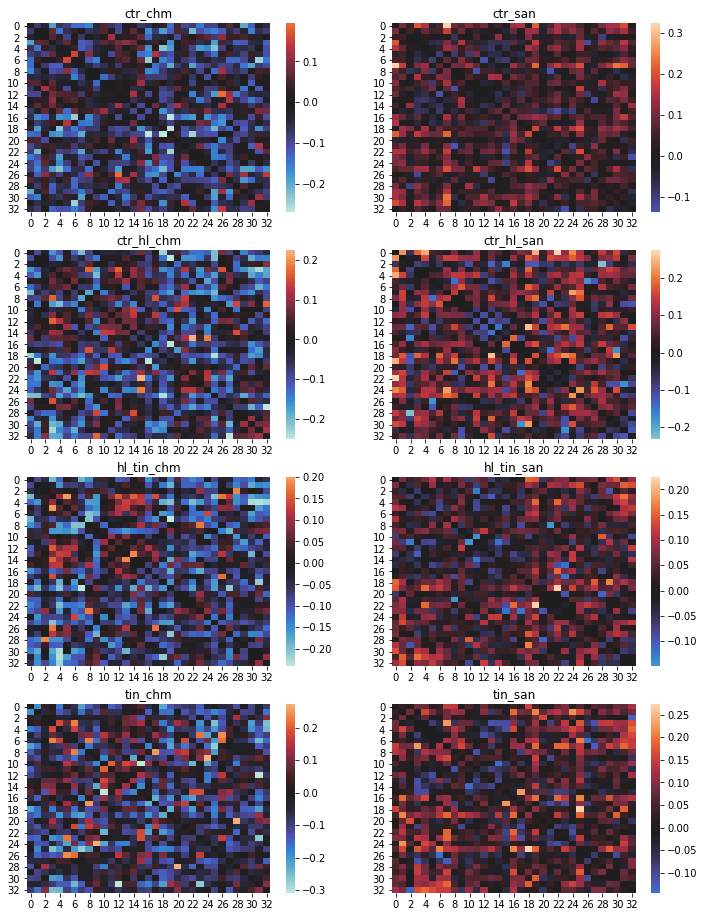

In [241]:
fig,axs = plt.subplots(4,2,figsize=(12,16))
for cls,ind_list in enumerate(class_indices):
    mean = np.mean([transformed[i] for i in ind_list],axis=0)
    axs[cls//2,cls%2].set_title(class_list[cls])
    sn.heatmap(mean-(mean*np.eye(mean.shape[0])),center=0,ax=axs[cls//2,cls%2])
plt.savefig('RiemannResults/AvgCovMatRiem.png',bbox_inches='tight')

In [237]:
covs = clf_riem[0].transform(X)

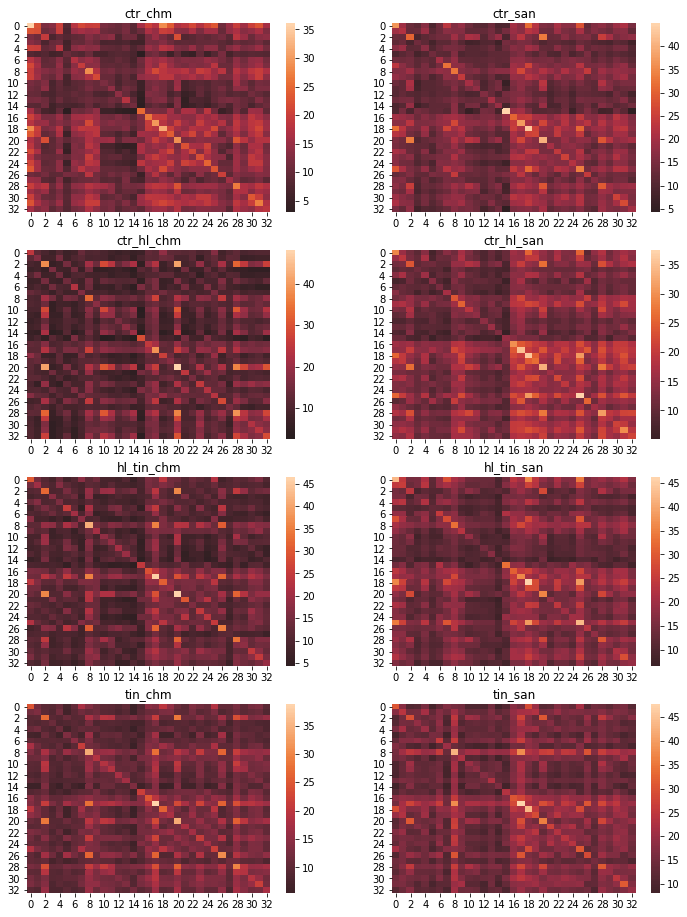

In [242]:
fig,axs = plt.subplots(4,2,figsize=(12,16))
for cls,ind_list in enumerate(class_indices):
    mean = np.mean([covs[i] for i in ind_list],axis=0)
    axs[cls//2,cls%2].set_title(class_list[cls])
    sn.heatmap(mean,center=0,ax=axs[cls//2,cls%2])
plt.savefig('RiemannResults/AvgCovMat.png',bbox_inches='tight')

In [104]:
corrDict

{'raw_data': {'before': 446.0469082844667, 'after': 71.8725787265269}}

In [105]:
spearDict

{'raw_data': {'before': 448.06076055527535, 'after': 258.88485381409475}}

In [106]:
simDict

{'wgsr_data33_tv_linear': [0.942028729430794,
  0.8526322491342517,
  0.947942698993155,
  0.887230826840282,
  0.9371915506194929,
  0.8715367648155433,
  0.9457087946218408,
  0.9340537841713843,
  0.8325322197282903,
  0.934357381041704,
  0.8116078842707006,
  0.9301171213853774,
  0.7968864176687607,
  0.9426061277014154,
  0.8519564149758001,
  0.9224061269162027,
  0.8729797126905868,
  0.9377193756760086,
  0.9414083451896793,
  0.8292748134491795,
  0.9486314217980253,
  0.82705595258849,
  0.9290587438069288,
  0.8670203960957431,
  0.9321099938900123,
  0.9349277239452981,
  0.7904832175600878,
  0.9381447074538826]}

In [107]:
y_pred

array([1, 7, 7, 7, 4, 3, 5, 3, 4, 4, 1, 1, 4, 5, 3, 6, 7, 4, 5, 1, 6, 5,
       5, 5, 1, 5, 3, 3, 2, 2, 4, 0, 2, 3, 2, 1, 4, 4, 5, 3, 0, 2, 5, 4,
       2, 1, 5, 4, 5, 7, 2, 1, 2, 3, 0, 0, 6, 3, 4, 4, 3, 5, 0, 7, 4, 2,
       5, 2, 7, 1, 4, 5, 5, 0, 0, 5, 5, 2, 5, 6, 0, 3, 5, 6, 0, 1, 5, 6,
       1, 1, 5, 3, 7, 7, 4, 2, 1, 4, 5, 2, 7, 3, 0, 4, 1, 4, 4, 5, 5, 6,
       4, 1, 5, 5, 0, 1, 6, 5, 2, 1, 1, 5, 6, 3, 1, 4, 6, 7, 7, 0, 5, 5,
       2, 2, 5, 2, 4, 5, 5, 5, 7, 5, 3])

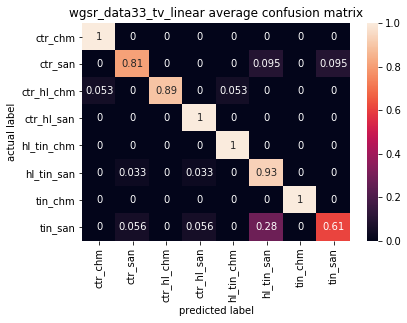

In [108]:
plt.figure()
df_cm = pd.DataFrame(mat, index = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'],
                      columns = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'])

sn.heatmap(df_cm, annot=True)
plt.title(fname + " average confusion matrix")
plt.ylabel('actual label')
plt.xlabel('predicted label')
plt.savefig('RiemannResults/'+'new_data'+'/AvgConfMat8class.png',bbox_inches='tight')

### Divide by sum along rows to normalize by total predictions in a given class 

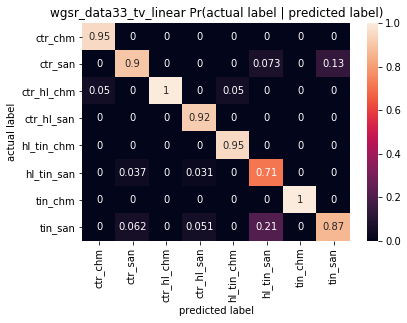

In [109]:
plt.figure()
df_cm = pd.DataFrame(mat/np.sum(mat,axis=0), index = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'],
                  columns = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','hl_tin_chm','hl_tin_san','tin_chm','tin_san'])

sn.heatmap(df_cm, annot=True)
plt.title(fname + " Pr(actual label | predicted label)")
plt.ylabel('actual label')
plt.xlabel('predicted label')
plt.savefig('RiemannResults/'+'new_data'+'/ConditionalAvgConfMat8Class.png',bbox_inches='tight')

### Get discriminative connections

In [265]:
data = {'samples':uiuc_samples+whasc_samples}
# First, make null model
# Use integer labeling so we can be sure that the one vs one classifiers are 
# in the correct orders
X = np.array([sample['TimeSeries'] for sample in data['samples'] if data_selector(sample)])        
y = np.array([get_label_8(sample['Group'],sample['Location']) for sample in data['samples'] if data_selector(sample)])
# Randomly permute labels (only labels, not training input)

NUM_BOOTSTRAP = 10
covest = Covariances()
ts = TangentSpace()
sym_mat = to_symm_mat(0,33)
ut = to_upper_tri(1)
svc = SVC(kernel='linear')
clf_riem = make_pipeline(covest,ts,sym_mat,ut,svc)
maxcoeffs = []   
mincoeffs = []
nullcoeffs = []
nullcos = []
for i in range(0,100):
    y_permuted = np.random.permutation(y)
    coeffArr = []
    rs = ShuffleSplit(n_splits=NUM_BOOTSTRAP, test_size=.3)
    for train,test in rs.split(X):
        X_train, X_test, y_train, y_test = X[train],X[test],y_permuted[train],y_permuted[test]
        clf_riem.fit(X_train,y_train)
        coeffArr.append(clf_riem[4].coef_/np.std(clf_riem[4].coef_,axis=-1).reshape(28,1))
        
    meancoeff = sum(coeffArr)/len(coeffArr)
    classcos = []
    for z in range(0,len(coeffArr[0])):
        class_z_coeffs = [x[z] for x in coeffArr]
        cos_sim = cosine_similarity(class_z_coeffs)
        upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
        cos_max = np.max(upperTri.flatten())
        classcos.append(cos_max)
        
    nullcos.append(classcos)
    nullcoeffs.append(meancoeff)
    maxcoeff = np.max(meancoeff,axis=-1)
    mincoeff = np.min(meancoeff,axis=-1)
    maxcoeffs.append(maxcoeff)
    mincoeffs.append(mincoeff)
    
coeffArr = []
rs = ShuffleSplit(n_splits=NUM_BOOTSTRAP, test_size=.3)
for train,test in rs.split(X):
    X_train, X_test, y_train, y_test = X[train],X[test],y[train],y[test]
    clf_riem.fit(X_train,y_train)
    coeffArr.append(clf_riem[4].coef_/np.std(clf_riem[4].coef_,axis=-1).reshape(28,1))
meancoeff = sum(coeffArr)/len(coeffArr)
classcos = []
for z in range(0,len(coeffArr[0])):
    class_z_coeffs = [x[z] for x in coeffArr]
    cos_sim = cosine_similarity(class_z_coeffs)
    upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
    cos_max = np.max(upperTri.flatten())
    classcos.append(upperTri.flatten())
cossims=[classcos]


In [266]:
mean_cossims = [np.mean(x) for x in cossims[0]]

In [267]:
mean_cossims

[0.8952524989017814,
 0.8222381649496578,
 0.8882787887009161,
 0.8426676558643772,
 0.8587019845153876,
 0.7736831201170373,
 0.8918598849234287,
 0.8814010947405706,
 0.7806094506155454,
 0.8874930770337035,
 0.7568340229138989,
 0.8341772441788974,
 0.673650058850044,
 0.8838182120887248,
 0.7930289433441372,
 0.8534546313594638,
 0.745659277276738,
 0.8810877865461151,
 0.8885211884620896,
 0.8049680974541477,
 0.8425365987745829,
 0.7768190375913101,
 0.8704471110674198,
 0.7354536987921969,
 0.895592952442215,
 0.8035243961728255,
 0.7057626448705476,
 0.8483601804759235]

In [268]:
null_dist = np.array(nullcos).T

In [269]:
null_dist_thresh = [np.percentile(x,97) for x in null_dist]

In [270]:
null_dist_thresh

[0.9041800554613908,
 0.9016564297416616,
 0.9057342917141803,
 0.8892129684933295,
 0.9045294171030656,
 0.9314960621277807,
 0.8944810332337916,
 0.8543072927153377,
 0.8906438010422674,
 0.8670185928063934,
 0.8397028989396271,
 0.9149103291970754,
 0.8618743298426577,
 0.8764159679428123,
 0.8625384979154568,
 0.8676978958952382,
 0.9268066444572152,
 0.8702800118509773,
 0.8906638529457004,
 0.8781418916077918,
 0.9311426259156691,
 0.887273531969436,
 0.8502377461632783,
 0.9182182866643942,
 0.8673189315169152,
 0.9244561994017064,
 0.8656658179812459,
 0.914899209361093]

In [271]:
mean_cossims > null_dist_thresh

False

In [272]:
def ind_to_pair(ind):
    x,y = np.triu_indices(33)
    return (x[ind],y[ind])

In [273]:
def get_sig_pairs(data,coeffarr,nullcoeffs,p,maxmin="max"):
    rois = data.rois
    if maxmin == "max":
        percentile = 100-p
    elif maxmin == "min":
        percentile = p
    thresholds = np.percentile(nullcoeffs,percentile,axis=0)
    if maxmin == "max":
        boolarr =  coeffarr > thresholds.reshape(28,1)
    elif maxmin == "min":
        boolarr = coeffarr < thresholds.reshape(28,1)
    indarr = [[(rois[ind_to_pair(x)[0]],rois[ind_to_pair(x)[1]]) for i,x in enumerate(range(0,len(boolarr[0]))) if boolarr[j][i]] for j in range(0,len(boolarr))]
    return indarr

In [274]:
sig_pairs_max = get_sig_pairs(data_old,meancoeff,maxcoeffs,5,"max")

In [275]:
sig_pairs_min = get_sig_pairs(data_old,meancoeff,mincoeffs,5,"min")

In [276]:
label_list = ['ctr_chm','ctr_san','ctr_hl_chm','ctr_hl_san','tin_hl_chm','tin_hl_san','tin_chm','tin_san']

In [277]:
import itertools
cmpr_list = list(itertools.combinations(label_list,2))

In [278]:
discrim_dict_max = {cmpr_list[i]: sig_pairs_max[i] for i in range(0,28)}

In [279]:
discrim_dict_max

{('ctr_chm', 'ctr_san'): [],
 ('ctr_chm', 'ctr_hl_chm'): [],
 ('ctr_chm', 'ctr_hl_san'): [],
 ('ctr_chm', 'tin_hl_chm'): [],
 ('ctr_chm', 'tin_hl_san'): [],
 ('ctr_chm', 'tin_chm'): [],
 ('ctr_chm', 'tin_san'): [],
 ('ctr_san', 'ctr_hl_chm'): [('lamygdala', 'lmidfrontalgyrus'),
  ('precuneus', 'rfrontaleyefield')],
 ('ctr_san', 'ctr_hl_san'): [],
 ('ctr_san', 'tin_hl_chm'): [('lamygdala', 'lmidfrontalgyrus')],
 ('ctr_san', 'tin_hl_san'): [],
 ('ctr_san', 'tin_chm'): [],
 ('ctr_san', 'tin_san'): [],
 ('ctr_hl_chm', 'ctr_hl_san'): [],
 ('ctr_hl_chm', 'tin_hl_chm'): [],
 ('ctr_hl_chm', 'tin_hl_san'): [],
 ('ctr_hl_chm', 'tin_chm'): [],
 ('ctr_hl_chm', 'tin_san'): [],
 ('ctr_hl_san', 'tin_hl_chm'): [('lanteriorinsula', 'lcuneus')],
 ('ctr_hl_san', 'tin_hl_san'): [],
 ('ctr_hl_san', 'tin_chm'): [],
 ('ctr_hl_san', 'tin_san'): [],
 ('tin_hl_chm', 'tin_hl_san'): [],
 ('tin_hl_chm', 'tin_chm'): [],
 ('tin_hl_chm', 'tin_san'): [],
 ('tin_hl_san', 'tin_chm'): [],
 ('tin_hl_san', 'tin_san'): [],


In [280]:
discrim_dict_min = {cmpr_list[i]: sig_pairs_min[i] for i in range(0,28)}

In [281]:
discrim_dict_min

{('ctr_chm', 'ctr_san'): [('lamygdala', 'lmidfrontalgyrus'),
  ('posteriorcingulatecortex', 'rsuperiortemporalsulcus'),
  ('precuneus', 'rfrontaleyefield')],
 ('ctr_chm', 'ctr_hl_chm'): [],
 ('ctr_chm', 'ctr_hl_san'): [('precuneus', 'rsuperiortemporalsulcus')],
 ('ctr_chm', 'tin_hl_chm'): [('posteriorcingulatecortex', 'rmidfrontalgyrus')],
 ('ctr_chm', 'tin_hl_san'): [('precuneus', 'rsuperiortemporalsulcus')],
 ('ctr_chm', 'tin_chm'): [],
 ('ctr_chm', 'tin_san'): [('medialprefrontalcortex', 'ranteriorinsula'),
  ('precuneus', 'rfrontaleyefield')],
 ('ctr_san', 'ctr_hl_chm'): [],
 ('ctr_san', 'ctr_hl_san'): [],
 ('ctr_san', 'tin_hl_chm'): [],
 ('ctr_san', 'tin_hl_san'): [],
 ('ctr_san', 'tin_chm'): [],
 ('ctr_san', 'tin_san'): [],
 ('ctr_hl_chm', 'ctr_hl_san'): [],
 ('ctr_hl_chm', 'tin_hl_chm'): [('lcuneus', 'rparahippocampus')],
 ('ctr_hl_chm', 'tin_hl_san'): [],
 ('ctr_hl_chm', 'tin_chm'): [('ranteriorinsula', 'rcuneus')],
 ('ctr_hl_chm', 'tin_san'): [],
 ('ctr_hl_san', 'tin_hl_chm'):

In [33]:
barheights = [[x for x in valdict.values()][:-1] for filename,valdict in accDict.items()] 

In [47]:
bheights = np.array(barheights).T

In [36]:
color = ['red','green','blue']

In [84]:
keys = list(x.rstrip('tv_linear') for x in accDict.keys())

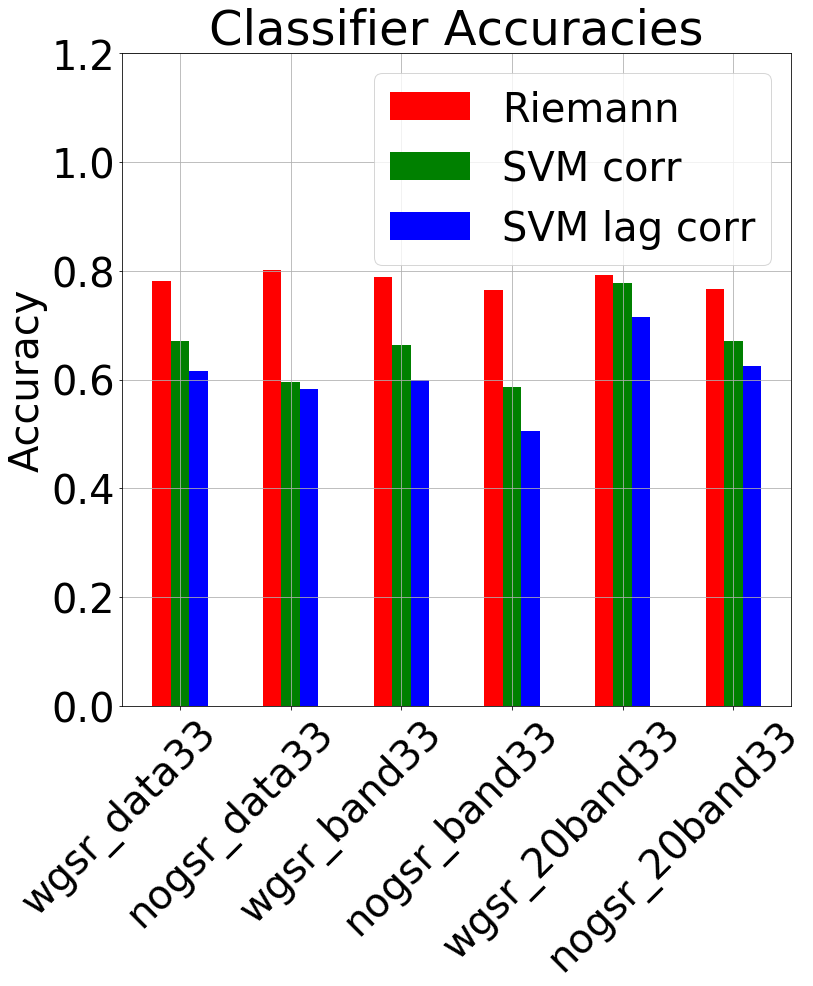

In [93]:
matplotlib.rcParams.update({'font.size': 40})
fig,ax = plt.subplots(figsize=(12,12))
ax.set_ylim(0,1.2)
ax.grid(True)
for i,filebar in enumerate(bheights):
    ax.bar([i/3+2*j for j,_ in enumerate(bheights[0])],filebar,color = color[i], 
           width = 1/3,tick_label = keys)
plt.xticks([1/3+2*j for j in range(0,6)], rotation=45)
plt.legend(['Riemann','SVM corr','SVM lag corr'])
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies')
dx = -60/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
plt.savefig('RiemannResults/Graphs/ClassAcc.png',bbox_inches='tight')

### Now use tin thresholds in class definitions

In [73]:
accDict = {}
simDict = {}
matDict = {}
corrDict = {}
for fname in fnames:
    with gzip.open(data_dir+fname + '.bin', 'rb') as stream:
        data = pickle.load(stream)
        
    simArr = []
        
    # get time series data to make covariance matrices
    X = np.array([sample['TimeSeries'] for sample in data.samples if data_selector(sample)])        
    y = np.array([get_label_4_tin_thresh(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    
    # gsr seems to produce a rank deficient covariance matrix, so oas regularization is necessary
    if fname.startswith('no'):
        covest = Covariances()
    else:
        covest = Covariances('oas')
    ts = TangentSpace()
    svc = SVC(kernel='linear')
    clf_riem = make_pipeline(covest,ts,svc)
        
    X_base = np.array([sample['CRM'][np.triu_indices(sample['CRM'].shape[0])].flatten() for sample in data.samples if data_selector(sample)])
    y_base = np.array([get_label_4_tin_thresh(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    svc_base = SVC(kernel='linear')
    clf_base = svc_base
    
    X_lag = np.array([sample['LCM'][np.triu_indices(sample['LCM'].shape[0])].flatten() for sample in data.samples if data_selector(sample)])
    y_lag = np.array([get_label_4_tin_thresh(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    svc_lag = SVC(kernel='linear')
    clf_lag = svc_lag
    
    clf_composite = SVC(kernel='linear')
    
    #Check clustering
    #to_TS = make_pipeline(covest,ts)
    #X_in_TS = to_TS.transform(X)
    #kmeans = KMeans(n_clusters=4,random_state=0).fit(X_in_TS)
            
    # Monte Carlo, in theory should run this len(y)^2 times, but I need to save my poor computer's memory.
    accRiemList = []
    accBaseList = []
    accLagList = []
    accCompList = []
    coeffArr = []
    matRiemList = []
    matBaseList = []
    matLagList = []
    corrArrBefore = []
    corrArrAfter = []

    rs = StratifiedShuffleSplit(n_splits=100, test_size=.3)
    for i,(train_inds,test_inds) in enumerate(rs.split(X,y)):
        X_train, X_test, y_train, y_test = X[train_inds],X[test_inds],y[train_inds],y[test_inds]
        X_train_base, X_test_base, y_train_base, y_test_base = X_base[train_inds],X_base[test_inds],y_base[train_inds],y_base[test_inds]
        X_train_lag, X_test_lag, y_train_lag, y_test_lag = X_lag[train_inds],X_lag[test_inds],y_lag[train_inds],y_lag[test_inds]
        
        clf_riem.fit(X_train,y_train)
        clf_base.fit(X_train_base,y_train_base)
        clf_lag.fit(X_train_lag,y_train_lag)
        clf_composite.fit(X_train_lag,y_train_lag)
        
        #get riemann svm coefficients
        coeffArr.append(clf_riem[2].coef_)
            
        #compare correlation
        corr_coeffs_before = np.corrcoef(np.vstack([x[np.triu_indices(33)].flatten() for x in X_train]),rowvar=False)
        corrArrBefore.append(np.linalg.norm(corr_coeffs_before))
        
        ref = ts.reference_
        covs = covest.transform(X_train)
        mapped = ts.transform(covs)
        corr_coeffs_after = np.corrcoef(mapped,rowvar=False)
        corrArrAfter.append(np.linalg.norm(corr_coeffs_after))
        
        
        #for flattened in mapped:
            
            #mat = np.zeros((33,33))
            #mat[np.triu_indices(33)] = flattened
            #mat = (mat + mat.T)/2
            #mapped_mats.append(mat)
            
        #print(np.mean(np.array([distance_riemann(x,ref) for x in covs])-np.array([np.linalg.norm(x,ord='fro') for x in mapped_mats])/np.array([distance_riemann(x,ref) for x in covs])))
        
        y_pred = clf_riem.predict(X_test)
        y_pred_base = clf_base.predict(X_test_base)
        y_pred_lag = clf_lag.predict(X_test_lag)
        
        # save accuracy
        accRiemList.append(accuracy_score(y_pred,y_test))
        accBaseList.append(accuracy_score(y_pred_base,y_test_base))
        accLagList.append(accuracy_score(y_pred_lag,y_test_lag))
        accCompList.append(accuracy_score(clf_composite.predict(X_test_base),y_test_base))
        
        # confusion matrix
        mat = confusion_matrix(y_test,y_pred,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_riem, X_test, y_test,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatRiemRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        mat_base = confusion_matrix(y_test_base,y_pred_base,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_base, X_test_base, y_test_base,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatBaseRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        mat_lag = confusion_matrix(y_test_lag,y_pred_lag,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_lag, X_test_lag, y_test_lag,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatLagRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        
        matRiemList.append(mat)
        matBaseList.append(mat_base)
        matLagList.append(mat_lag)
    
    for z in range(0,len(coeffArr[0])):
        class_z_coeffs = [x[z] for x in coeffArr]
        cos_sim = cosine_similarity(class_z_coeffs)
        upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
        cos_avg = np.mean(upperTri.flatten())
        simArr.append(cos_avg)
        
    avgMatRiem = sum(matRiemList)/len(matRiemList)
    simDict.update({fname: simArr}) 
    matDict.update({fname: avgMatRiem})
    riemAcc = np.mean(accRiemList)
    baseAcc = np.mean(accBaseList)
    lagAcc = np.mean(accLagList)
    compAcc = np.mean(accCompList)
    accDict.update({fname:{'riem':riemAcc, 'base': baseAcc,'lag': lagAcc,'comp':compAcc}})
    corrDict.update({fname:{'before':np.mean(corrArrBefore),'after':np.mean(corrArrAfter)}})        
    print("Mean Accuracy w/ Riemann on file " + fname + ": " + str(riemAcc))
    print("Mean Accuracy w/ Base on file " + fname + ": " + str(baseAcc))
    print("Mean Accuracy w/ Lag on file " + fname + ": " + str(lagAcc))
    print("Mean Accuracy w/ Composite on file " + fname + ": " + str(compAcc))
    print("----------------")


Mean Accuracy w/ Riemann on file wgsr_data33_tv_linear: 0.8413793103448276
Mean Accuracy w/ Base on file wgsr_data33_tv_linear: 0.7198850574712644
Mean Accuracy w/ Lag on file wgsr_data33_tv_linear: 0.68
Mean Accuracy w/ Composite on file wgsr_data33_tv_linear: 0.6279310344827587
----------------
Mean Accuracy w/ Riemann on file nogsr_data33_tv_linear: 0.8542528735632186
Mean Accuracy w/ Base on file nogsr_data33_tv_linear: 0.6063218390804598
Mean Accuracy w/ Lag on file nogsr_data33_tv_linear: 0.5965517241379311
Mean Accuracy w/ Composite on file nogsr_data33_tv_linear: 0.5666666666666667
----------------
Mean Accuracy w/ Riemann on file wgsr_band33_tv_linear: 0.8645977011494252
Mean Accuracy w/ Base on file wgsr_band33_tv_linear: 0.648735632183908
Mean Accuracy w/ Lag on file wgsr_band33_tv_linear: 0.5926436781609195
Mean Accuracy w/ Composite on file wgsr_band33_tv_linear: 0.6062068965517242
----------------
Mean Accuracy w/ Riemann on file nogsr_band33_tv_linear: 0.851609195402299


In [26]:
accDict = {}
simDict = {}
matDict = {}
corrDict = {}
for fname in fnames:
    with gzip.open(data_dir+fname + '.bin', 'rb') as stream:
        data = pickle.load(stream)
        
    simArr = []
        
    # get time series data to make covariance matrices
    X = np.array([sample['TimeSeries'] for sample in data.samples if data_selector(sample)])        
    y = np.array([get_label_4_tin_thresh2(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    
    # gsr seems to produce a rank deficient covariance matrix, so oas regularization is necessary
    if fname.startswith('no'):
        covest = Covariances()
    else:
        covest = Covariances('oas')
    ts = TangentSpace()
    svc = SVC(kernel='linear')
    clf_riem = make_pipeline(covest,ts,svc)
        
    X_base = np.array([sample['CRM'][np.triu_indices(sample['CRM'].shape[0])].flatten() for sample in data.samples if data_selector(sample)])
    y_base = np.array([get_label_4_tin_thresh2(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    svc_base = SVC(kernel='linear')
    clf_base = svc_base
    
    X_lag = np.array([sample['LCM'][np.triu_indices(sample['LCM'].shape[0])].flatten() for sample in data.samples if data_selector(sample)])
    y_lag = np.array([get_label_4_tin_thresh2(sample['Group'],sample['Name'],metadata) for sample in data.samples if data_selector(sample)])
    svc_lag = SVC(kernel='linear')
    clf_lag = svc_lag
    
    clf_composite = SVC(kernel='linear')
    
    #Check clustering
    #to_TS = make_pipeline(covest,ts)
    #X_in_TS = to_TS.transform(X)
    #kmeans = KMeans(n_clusters=4,random_state=0).fit(X_in_TS)
            
    # Monte Carlo, in theory should run this len(y)^2 times, but I need to save my poor computer's memory.
    accRiemList = []
    accBaseList = []
    accLagList = []
    accCompList = []
    coeffArr = []
    matRiemList = []
    matBaseList = []
    matLagList = []
    corrArrBefore = []
    corrArrAfter = []

    rs = StratifiedShuffleSplit(n_splits=100, test_size=.3)
    for i,(train_inds,test_inds) in enumerate(rs.split(X,y)):
        X_train, X_test, y_train, y_test = X[train_inds],X[test_inds],y[train_inds],y[test_inds]
        X_train_base, X_test_base, y_train_base, y_test_base = X_base[train_inds],X_base[test_inds],y_base[train_inds],y_base[test_inds]
        X_train_lag, X_test_lag, y_train_lag, y_test_lag = X_lag[train_inds],X_lag[test_inds],y_lag[train_inds],y_lag[test_inds]
        
        clf_riem.fit(X_train,y_train)
        clf_base.fit(X_train_base,y_train_base)
        clf_lag.fit(X_train_lag,y_train_lag)
        clf_composite.fit(X_train_lag,y_train_lag)
        
        #get riemann svm coefficients
        coeffArr.append(clf_riem[2].coef_)
            
        #compare correlation
        corr_coeffs_before = np.corrcoef(np.vstack([x[np.triu_indices(33)].flatten() for x in X_train]),rowvar=False)
        corrArrBefore.append(np.linalg.norm(corr_coeffs_before))
        
        ref = ts.reference_
        covs = covest.transform(X_train)
        mapped = ts.transform(covs)
        corr_coeffs_after = np.corrcoef(mapped,rowvar=False)
        corrArrAfter.append(np.linalg.norm(corr_coeffs_after))
        
        
        #for flattened in mapped:
            
            #mat = np.zeros((33,33))
            #mat[np.triu_indices(33)] = flattened
            #mat = (mat + mat.T)/2
            #mapped_mats.append(mat)
            
        #print(np.mean(np.array([distance_riemann(x,ref) for x in covs])-np.array([np.linalg.norm(x,ord='fro') for x in mapped_mats])/np.array([distance_riemann(x,ref) for x in covs])))
        
        y_pred = clf_riem.predict(X_test)
        y_pred_base = clf_base.predict(X_test_base)
        y_pred_lag = clf_lag.predict(X_test_lag)
        
        # save accuracy
        accRiemList.append(accuracy_score(y_pred,y_test))
        accBaseList.append(accuracy_score(y_pred_base,y_test_base))
        accLagList.append(accuracy_score(y_pred_lag,y_test_lag))
        accCompList.append(accuracy_score(clf_composite.predict(X_test_base),y_test_base))
        
        # confusion matrix
        mat = confusion_matrix(y_test,y_pred,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_riem, X_test, y_test,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatRiemRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        mat_base = confusion_matrix(y_test_base,y_pred_base,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_base, X_test_base, y_test_base,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatBaseRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        mat_lag = confusion_matrix(y_test_lag,y_pred_lag,normalize='true',labels=[0,1,2,3])
        #plot_confusion_matrix(clf_lag, X_test_lag, y_test_lag,normalize='true',labels=['ctr','hl','tin_hl','tin'],display_labels=['ctr','ctr_hl','hl_tin','tin'])
        #plt.savefig('RiemannResults/' + fname + '/ConfMatLagRun' + str(i) + '.png',bbox_inches='tight')
        #plt.close()
        
        matRiemList.append(mat)
        matBaseList.append(mat_base)
        matLagList.append(mat_lag)
    
    for z in range(0,len(coeffArr[0])):
        class_z_coeffs = [x[z] for x in coeffArr]
        cos_sim = cosine_similarity(class_z_coeffs)
        upperTri = cos_sim[np.triu_indices(cos_sim.shape[0],1)]
        cos_avg = np.mean(upperTri.flatten())
        simArr.append(cos_avg)
        
    avgMatRiem = sum(matRiemList)/len(matRiemList)
    simDict.update({fname: simArr}) 
    matDict.update({fname: avgMatRiem})
    riemAcc = np.mean(accRiemList)
    baseAcc = np.mean(accBaseList)
    lagAcc = np.mean(accLagList)
    compAcc = np.mean(accCompList)
    accDict.update({fname:{'riem':riemAcc, 'base': baseAcc,'lag': lagAcc,'comp':compAcc}})
    corrDict.update({fname:{'before':np.mean(corrArrBefore),'after':np.mean(corrArrAfter)}})        
    print("Mean Accuracy w/ Riemann on file " + fname + ": " + str(riemAcc))
    print("Mean Accuracy w/ Base on file " + fname + ": " + str(baseAcc))
    print("Mean Accuracy w/ Lag on file " + fname + ": " + str(lagAcc))
    print("Mean Accuracy w/ Composite on file " + fname + ": " + str(compAcc))
    print("----------------")

Mean Accuracy w/ Riemann on file wgsr_data33_tv_linear: 0.835632183908046
Mean Accuracy w/ Base on file wgsr_data33_tv_linear: 0.7134482758620687
Mean Accuracy w/ Lag on file wgsr_data33_tv_linear: 0.6798850574712643
Mean Accuracy w/ Composite on file wgsr_data33_tv_linear: 0.6348275862068965
----------------
Mean Accuracy w/ Riemann on file nogsr_data33_tv_linear: 0.8495402298850574
Mean Accuracy w/ Base on file nogsr_data33_tv_linear: 0.6511494252873564
Mean Accuracy w/ Lag on file nogsr_data33_tv_linear: 0.6395402298850574
Mean Accuracy w/ Composite on file nogsr_data33_tv_linear: 0.6136781609195403
----------------
Mean Accuracy w/ Riemann on file wgsr_band33_tv_linear: 0.8419540229885056
Mean Accuracy w/ Base on file wgsr_band33_tv_linear: 0.6549425287356321
Mean Accuracy w/ Lag on file wgsr_band33_tv_linear: 0.6118390804597701
Mean Accuracy w/ Composite on file wgsr_band33_tv_linear: 0.624367816091954
----------------
Mean Accuracy w/ Riemann on file nogsr_band33_tv_linear: 0.832